## Linking Components with Messages
In this demo, you will learn how components can be linked together using messages. We will do this by extending the power system generated in the previous demo to include a reaction wheel that consumes power. This demo involves the following steps:
1. Define the power consumption properties of the reaction wheels.
2. Replace the guidance computer with manually defined flight software components.
2. Link the power system and the reaction wheel using messages
3. Plot the power consumption of the reaction wheels.

In [1]:
# nominalpy imports
from nominalpy import Credentials, Simulation, System, Object, types
from nominalpy.maths import astro
# other imports
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

from scenarios.credential_helper import fetch_credentials

### Authenticate your nominalpy access


In [2]:
# Construct the credentials
credentials = fetch_credentials()

simulation: Simulation = Simulation.get(credentials)

### Setup the spacecraft and components
The following cells configure the spacecraft and its components. For more details, please refer to the Power System demo.

In [3]:
# universe configuration parameters
epoch = datetime(2023, 1, 1)

# get the universe associated with our simulation, setting it with a desired epoch
universe: System = simulation.get_system(
    types.SOLAR_SYSTEM,
    Epoch=epoch
)

In [4]:
# satellite configuration parameters
mass = 750  # kg
center_of_mass = np.array([0.0, 0.0, 0.0])  # m
moment_of_inertia = np.diag([900, 800, 600])  # kg m^2

semi_major_axis = 7000e3  # m
eccentricity = 0.001
inclination = 97.5  # deg
raan = 5  # deg
arg_perigee = 10  # deg
true_anomaly = 20  # deg

# initial attitude and rate, defined in modified rodriquez parameters
attitude = np.array([0.1, 0.2, -0.3])
attitude_rate = np.array([0.001, -0.01, 0.03])

In [5]:
# convert the classical orbital elements to state vectors, using nominalpy's utility functions, to help initialise the orbit
orbit: tuple = astro.classical_to_vector_elements_deg(
    semi_major_axis=semi_major_axis,
    eccentricity=eccentricity,
    inclination=inclination,
    right_ascension=raan,
    argument_of_periapsis=arg_perigee,
    true_anomaly=true_anomaly,
)

# add the satellite object to the simulation
# nominalpy can either hard-set the mass, center of mass, and moment of inertia properties of the spacecraft; or calculate them based on attached components. In this simple case, we will hard-set the by setting the OverrideMass property to True.
spacecraft: Object = simulation.add_object(
    types.SPACECRAFT,
    TotalMass=mass,
    TotalCenterOfMassB_B=center_of_mass,  # com of mass of the spacecraft in the body frame
    TotalMomentOfInertiaB_B=moment_of_inertia,  # moment of inertia of the spacecraft in the body frame
    OverrideMass=True,
    Position=orbit[0],
    Velocity=orbit[1],
    Attitude=attitude,
    AttitudeRate=attitude_rate,
)

In [6]:
# Adds a reaction wheel array as a child component of the spacecraft. The reaction wheel array makes tracking data for individual reaction wheels much easier.
reaction_wheels: Object = spacecraft.add_child("ReactionWheelArray")

# Adds individual reaction wheels to the reaction wheel array using the same add_child method. The reaction wheels are initialised within default properties such as max wheel speed, max torque, etc... These properties can be overridden by setting the desired properties in the add_child method. In this case, we set the wheel spin axes to be aligned with the body frame axes.
rw1: Object = reaction_wheels.add_child(
    "ReactionWheel",
    WheelSpinAxis_B=np.array([1, 0, 0])
)
rw2: Object = reaction_wheels.add_child(
    "ReactionWheel",
    WheelSpinAxis_B=np.array([0, 1, 0])
)
rw3: Object = reaction_wheels.add_child(
    "ReactionWheel",
    WheelSpinAxis_B=np.array([0, 0, 1])
)

### Add the power components

In [7]:
# Adds a solar panel
solar_panel = spacecraft.add_child(
    "SolarPanel",
    Area=0.014,
    Efficiency=0.23
)
solar_panel.invoke("RollDegrees", 90.0)

# Add in a battery. The battery will be set to default battery capacity and other parameters will be set to default values unless overwritten. We will overwrite the ChargeFraction.
battery = spacecraft.add_child(
    "Battery",
    ChargeFraction=0.8
)

# Add in a power bus and connect up the solar panel and battery
bus = spacecraft.add_child(
    "PowerBus",
)

## 1. Define the power consumption properties of the reaction wheel

The reaction wheel components, have a power model that allows the user to define the power consumption properties of the wheels. 

In [8]:
# Connect battery to power bus
bus.invoke("ConnectBattery", battery)
bus.invoke("Connect", solar_panel, battery)
# Connect battery to reaction wheels
bus.invoke(
    "ConnectBatteryComponent",
    battery,
    reaction_wheels
)

# Fetch the power model from the reaction wheel object
rw_motor_power_model = reaction_wheels.get_model("ReactionWheelArrayPowerModel")

# Use a lookup table approach to define the power consumption properties of the reaction wheels based on (voltage command [V], power draw [W]). We do this by invoking a method that will update the object in-place.
rw_motor_power_model.invoke("AddLookupTableEntry", 0.1, 0.1)
rw_motor_power_model.invoke("AddLookupTableEntry", 3.0, 5.0)
rw_motor_power_model.invoke("AddLookupTableEntry", 10.0, 20.0)
rw_motor_power_model.invoke("AddLookupTableEntry", 20.0, 50.0)

## 2. Replace the guidance computer with manually defined flight software components
This architecture allows component modules to exchange data with each other using messages. Each component has a set of input and output messages that can be connected to other components. The following cells replace the guidance computer with manually defined flight software components and demonstrates the use of input (In_) and output (Out_) messages to link the components.

To find a full list of components, their messages, and other properties, please search for them in the API Reference at (https://docs.nominalsys.com/v0.9/api/index.html).

#### Adding Software Components as "Behaviours"
You may notice that the flight software modules, such as SimpleNavigationSoftware component, are added to the spacecraft using an add_behaviour method instead of .add_child(). This is because the flight software components don't have a physical representation, mass, inertia or other physical properties, and so, is categorised differently to other objects in the simulation.

In [9]:
# Add the simple navigator flight software module which will give us the spacecraft's state and attitude
navigator: Object = spacecraft.add_behaviour("SimpleNavigationSoftware")

# Add ephemeris navigation software which will give us the planet's state
# here, the PlanetEphemerisTranslationSoftware has in input In_PlanetStateMsg which can be linked to the Out_PlanetStateMsg of the planet object accessed from the simulation. The linking of the messages allows the software module to track the simulated state of the planet according to the time and other properties of the simulation.
ephemeris_fsw: Object = spacecraft.add_behaviour(
    "PlanetEphemerisTranslationSoftware",
    In_PlanetStateMsg=simulation.get_planet("earth").get_message("Out_PlanetStateMsg")
)

# Add nadir pointing software, this flight software module will translate the known state of the spacecraft (from the simple navigation module) and the planet (from the PlanetEphemerisTranslationSoftware) into desired attitude guidance. Therefore, we link its required input messages to the output messages of software modules on which it depends.
lvlh_fsw: Object = spacecraft.add_behaviour(
    "NadirPointingSoftware",
    In_NavigationTranslationMsg=navigator.get_message("Out_NavigationTranslationMsg"),
    In_EphemerisMsg=ephemeris_fsw.get_message("Out_EphemerisMsg")
)

# Add attitude reference error software, converts the spacecraft's current attitude to the desired attitude into an error signal that can be fed into future flight software modules.
attitude_tracking_error_fsw: Object = spacecraft.add_behaviour(
    "AttitudeReferenceErrorSoftware",
    In_NavigationAttitudeMsg=navigator.get_message("Out_NavigationAttitudeMsg"),  # input the current attitude of the spacecraft from the output message of the simple navigator
    In_AttitudeReferenceMsg=lvlh_fsw.get_message("Out_AttitudeReferenceMsg")  # input the 
)

# Add MRP feedback control software, this is a PID controller that will take input from the attitude tracking error software and output from the reaction wheels.
mrp_feedback_fsw: Object = spacecraft.add_behaviour(
    "MRPFeedbackControlSoftware",
    K=3.5,
    P=30.0,
    Ki=-1.0,
    IntegralLimit=2.0 / -1.0 * 0.1,
    In_AttitudeErrorMsg=attitude_tracking_error_fsw.get_message("Out_AttitudeErrorMsg"),  # input the attitude error from the attitude tracking error software
    In_RWArraySpeedMsg=reaction_wheels.get_message("Out_RWArraySpeedMsg"),  # input the speed of the reaction wheels from the reaction wheel array
    In_RWArrayConfigMsg=reaction_wheels.get_message("Out_RWArrayConfigMsg")  # input the configuration of the reaction wheel array
)

# Add reaction wheel motor torque software, this software module converts the output of the MRP feedback control software into motor torques that can be applied to the reaction wheels.
rw_motor_torque_fsw: Object = spacecraft.add_behaviour(
    "RWTorqueMappingSoftware",
    In_RWArrayConfigMsg=reaction_wheels.get_message("Out_RWArrayConfigMsg"),
    ControlAxes_B=np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]),
    In_CommandTorqueMsg=mrp_feedback_fsw.get_message("Out_CommandTorqueMsg"),
)

# in this demo we want to change pointing modes to Sun pointing. Therefore, prepare the Sun pointing software module to remap the software modules after we propagate.
# Add the Sun pointing software
sun_point = spacecraft.add_behaviour(
    "SunSafePointingSoftware",
    MinUnitMag=0.001,
    SmallAngle=0.001,
    SunBodyVector=solar_panel.get("RelativeNormal"),
    Omega_RN_B=np.array([0, 0, 0]),
    SunAxisSpinRate=0.0,
    In_NavigationAttitudeMsg=navigator.get_message("Out_NavigationAttitudeMsg"),
    In_SunDirectionMsg=navigator.get_message("Out_NavigationAttitudeMsg"),
)

## 3. Link the power system and the reaction wheel using messages
 Connect the power consumption properties of the reaction wheels to other flight software modules using messages. Done using a simular approach to the flight software above, we link the power consumption properties of the reaction wheels to the power system using messages. The types of input messages that the modules require and provide, can be found within the API Reference. An example of the API Reference for the RWVoltageMappingSoftware can be seen below.

![API Reference for RWVoltageMappingSoftware](./markdown/4_linking_components_via_messages/rwvoltagemappingsoftware_docs.png)]

In [10]:
# Add reaction wheel motor voltage software as a behaviour
rw_motor_voltage_fsw: Object = spacecraft.add_behaviour(
    "RWVoltageMappingSoftware",
    In_RWArrayConfigMsg=reaction_wheels.get_message("Out_RWArrayConfigMsg"),
    In_RWArraySpeedMsg=reaction_wheels.get_message("Out_RWArraySpeedMsg"),
    MaxVoltage=10,
    MinVoltage=0,
    In_MotorTorqueArrayMsg=rw_motor_torque_fsw.get_message("Out_MotorTorqueArrayMsg")
)

# Connect power model
rw_motor_power_model.set(
    In_MotorVoltageArrayMsg=rw_motor_voltage_fsw.get_message("Out_MotorVoltageArrayMsg")
)

# Add motor voltage device interface
rw_voltage_io: Object = spacecraft.add_behaviour(
    "VoltageTorqueConversionSoftware",
    Gain=np.array([0.02, 0.02, 0.02]),
    In_MotorVoltageArrayMsg=rw_motor_power_model.get_message("Out_MotorVoltageArrayMsg")
)

# Connect reaction wheels to motor torque message
reaction_wheels.set(
    In_MotorTorqueArrayMsg=rw_voltage_io.get_message("Out_MotorTorqueArrayMsg")
)

In [11]:
# subscribe to the data
# set the interval (in seconds) at which data is polled.
simulation.set_tracking_interval(interval=30)

# each object, system, and simulation contain data messages that can be subscribed to. Messages associated with each object can be found in the nominalpy documentation.
simulation.track_object(attitude_tracking_error_fsw.get_message("Out_AttitudeErrorMsg"))
simulation.track_object(spacecraft.get_message("Out_SpacecraftStateMsg"))

# subscribe to the power system messages
simulation.track_object(battery.get_message("Out_BatteryMsg"))
simulation.track_object(solar_panel.get_message("Out_PowerSourceMsg"))
simulation.track_object(rw_motor_power_model.get_message("Out_MotorVoltageArrayMsg"))
simulation.track_object(solar_panel.get_model("Universe.SolarModel").get_message("Out_EclipseMsg"))
simulation.track_object(sun_point.get_message("Out_AttitudeErrorMsg"))

In [12]:
duration = 4000  # sec
time_step = 0.1  # sec
simulation.tick_duration(step=time_step, time=duration)

#### Remapping the MRP feedback controller to the Sun pointing software

In [13]:
# Our attitude control flight software is already linked to the existing mrp_feedback_fsw object. Therefore, we have to update the properties of that existing object by using the set() method. In this case we will update its attitude error message to the Sun pointing software's attitude error message.
mrp_feedback_fsw.set(In_AttitudeErrorMsg=sun_point.get_message("Out_AttitudeErrorMsg"))

In [14]:
simulation.tick_duration(step=time_step, time=duration)

## 4. Plot the power consumption of the reaction wheels

### Plotting the battery capacity
When we plot the battery capacity we expect to see changes in the rate of charge based on the changing exposure of the solar panels to the Sun due to changes in the spacecraft's pointing mode and its orbit.

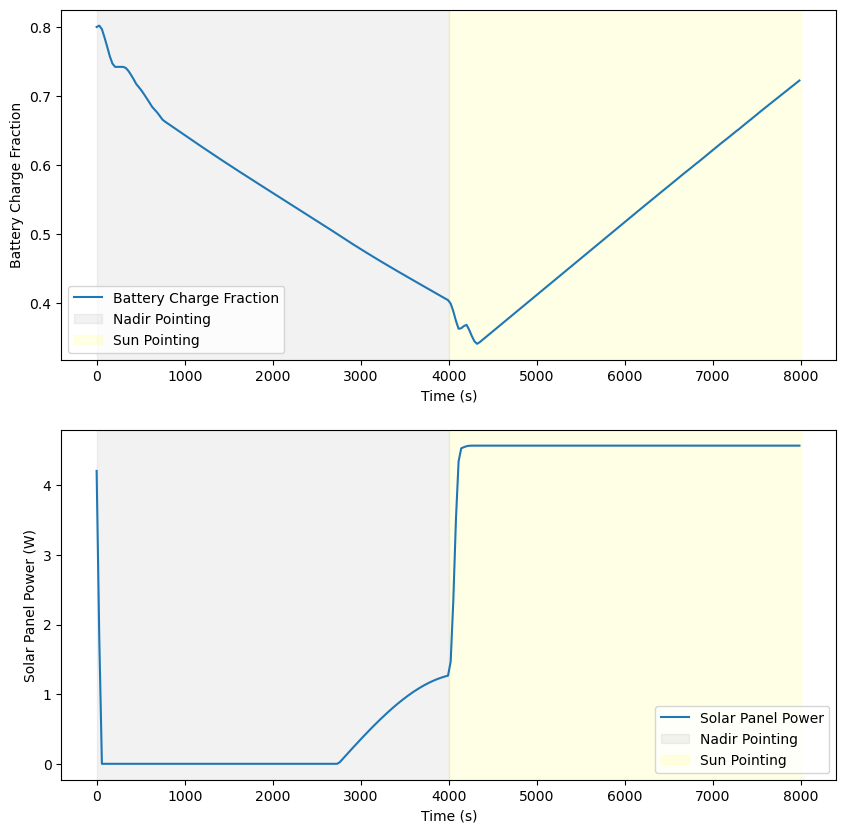

In [15]:
# get the battery data
df_battery = simulation.query_dataframe(battery.get_message("Out_BatteryMsg"))

# create two side-by-side plots, one plotting the battery capacity and the other plotting the power produced by the solar panels
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# plot the battery capacity
ax[0].plot(df_battery.loc[:, "Time"], df_battery.loc[:, "ChargeFraction"])
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Battery Charge Fraction")
# Add background shading to indicate the first half of the simulation as nadir pointing and the second half as sun pointing
ax[0].axvspan(0, duration, color='gray', alpha=0.1)
ax[0].axvspan(duration, 2 * duration, color='yellow', alpha=0.1)
# add a legend
ax[0].legend(["Battery Charge Fraction", "Nadir Pointing", "Sun Pointing"])

# plot the solar panel power and power out of the battery
df_solar_panel = simulation.query_dataframe(solar_panel.get_message("Out_PowerSourceMsg"))
ax[1].plot(df_solar_panel.loc[:, "Time"], df_solar_panel.loc[:, "Power"])
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Solar Panel Power (W)")

# Add background shading to indicate the first half of the simulation as nadir pointing and the second half as sun pointing
ax[1].axvspan(0, duration, color='gray', alpha=0.1)
ax[1].axvspan(duration, 2 * duration, color='yellow', alpha=0.1)
# add a legend
ax[1].legend(["Solar Panel Power", "Nadir Pointing", "Sun Pointing"])

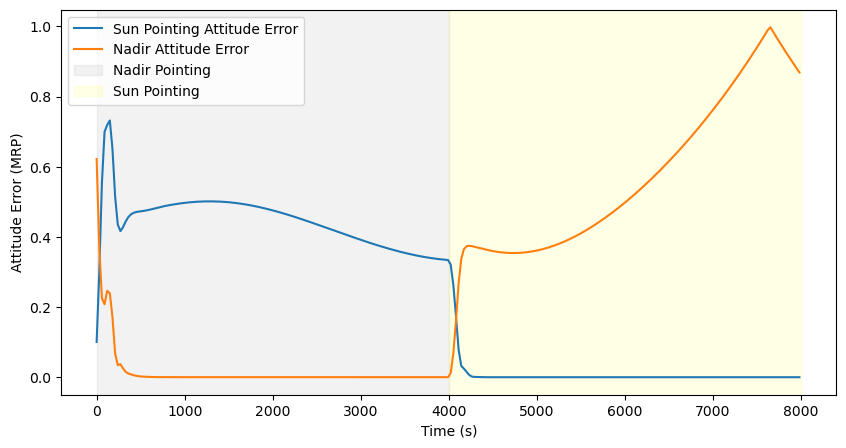

In [19]:
# plot the attitude error from the Sun pointing software and the attitude tracking error software
df_attitude_error = simulation.query_dataframe(sun_point.get_message("Out_AttitudeErrorMsg"))
df_attitude_tracking_error = simulation.query_dataframe(attitude_tracking_error_fsw.get_message("Out_AttitudeErrorMsg"))

# plot the SimpleNavigationSoftwarem of the attitude error |[Sigma_BR_0, Sigma_BR_1, Sigma_BR_2]|
# calculate the Euclidean norm of the attitude error
df_attitude_error["Sigma_BR"] = np.linalg.norm(df_attitude_error.loc[:, ["Sigma_BR_0", "Sigma_BR_1", "Sigma_BR_2"]], axis=1)
df_attitude_tracking_error["Sigma_BR"] = np.linalg.norm(df_attitude_tracking_error.loc[:, ["Sigma_BR_0", "Sigma_BR_1", "Sigma_BR_2"]], axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_attitude_error.loc[:, "Time"], df_attitude_error.loc[:, "Sigma_BR"])
ax.plot(df_attitude_tracking_error.loc[:, "Time"], df_attitude_tracking_error.loc[:, "Sigma_BR"])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Attitude Error (MRP)")
# add background shading to indicate the first half of the simulation as nadir pointing and the second half as sun pointing
ax.axvspan(0, duration, color='gray', alpha=0.1)
ax.axvspan(duration, 2 * duration, color='yellow', alpha=0.1)
# add a legend
ax.legend(["Sun Pointing Attitude Error", "Nadir Attitude Error", "Nadir Pointing", "Sun Pointing"])
